# Multivariate g-and-k distribution
This notebook contains the code for reproducing the results from Section 5.2 of the paper.

In [1]:
import numpy as np
import scipy.stats as stats # used for inverse Gaussian
import scipy.spatial.distance as distance # distance used for kernel
import matplotlib.pyplot as plt
import probnum as pn
import utils 

import time

from probnum.quad._integration_measures import (
    GaussianMeasure,
    IntegrationMeasure,
    LebesgueMeasure,
)
from probnum.randprocs.kernels import ExpQuad, Kernel, Matern, ProductMatern

from sklearn.gaussian_process.kernels import Matern as skMatern

## Functions

In [2]:
def MMD_weighted_general(x, y, u, lengthscale, measure = "Uniform", kernel = "Gaussian"):
    if measure=="Uniform" and kernel == "Gaussian":
        z = utils.embedding_unif(u)
        w = utils.computeWeights(u, z)
    elif measure == "Gaussian" and kernel == "Gaussian":
        z = utils.embedding_Gaussian(u)
        w = utils.computeWeights(u, z)
        
    return utils.MMD_weighted(x, y, w, lengthscale)

def normals_inv(u):
    # avoid origin
    u[u == 0] = np.nextafter(0, 1)
    # create standard normal samples
    z = stats.norm.ppf(u, loc=0, scale=1)
    return z

def embedding_Gaussian(u):
    # Function to compute the embedding when U is Gaussian distributed

    # Compute lengthscale for kernel c    
    l = utils.median_heuristic(u)

    dim = u.shape[1]
    m = u.shape[0]
    z = np.zeros(shape = (m,1))

    mu = 0
    sigma = 1

    for i in range(m):

        z[i] = (l**2 / (l**2 + sigma**2))**(dim/2) * np.exp(- np.linalg.norm(u[i,:])**2 / (2 * (l**2 + sigma**2)))
        
    return z

# Function to compute optimal weights when c is Matern kernel
def compute_weights_ProdMatern(u, dim, m, nu=2.5):

    l = utils.median_heuristic(u)
    ls = np.repeat(l, dim)
    nus = np.repeat(nu, dim)

    k = ProductMatern(input_shape=(dim,), lengthscales=ls, nus=nus)
    measure = LebesgueMeasure((0,1), dim)

    e = pn.quad.KernelEmbedding(k, measure)

    delta = 1e-8

    km = k.matrix(u)
    C = km + delta * np.identity(m)
    C_inv = np.linalg.inv(C)

    return np.matmul(C_inv, e.kernel_mean(u))

# generator for multivariate g-and-k distribution. Outputs uniform rvs u, Gaussian rvs z_standard and data x
def sample_mvgandk(input_values, n, dim, method = "MC"):
    A = input_values[0]
    B = input_values[1]
    g = input_values[2]
    k = input_values[3]
    rho = input_values[4]
    c = 0.8

    cov = np.eye(dim) + rho * np.eye(dim, k=1) + rho * np.eye(dim, k=-1)
    cov = np.eye(dim)
    L = np.linalg.cholesky(cov)

    if method == "MC":
        u = np.random.rand(n, dim)
    elif method == "QMC":
        sampler = stats.qmc.Sobol(d=dim, scramble=True)
        u = sampler.random_base2(9)
    
    z_standard = np.zeros(shape=u.shape)

    for i in range(dim):
        z_standard[:, i] = normals_inv(u[:, i])

    z = np.matmul(L, z_standard.transpose())
    z = z.transpose()
#     z = np.random.randn(n, dim)
    x = np.zeros(shape=(n, dim))

    for i in range(n):
        x[i, :] = A + B * (1 + c * ((1 - np.exp(-g * z[i, :])) / (1 + np.exp(-g * z[i, :])))) * ((1 + z[i, :] ** 2) **k) * z[i, :]

    return u, z_standard, x

### MMD error vs. dimension
This code produces the results shown in Fig 3 (centre-left)

In [182]:
# Parameter settings
m = 500                                  # number of simulated samples
n = 10000                                # number of true samples
theta = [3, 1, 0.1, 0.1, 0.1]            # true theta
dim = np.arange(5, 105, 5)               # dimensions of data

N = 100

In [183]:
MMDvals_Vstat = np.zeros(shape = (N,len(dim)))
MMDvals_weighted_uniform = np.zeros(shape = (N,len(dim)))
MMDvals_weighted_gaussian = np.zeros(shape = (N,len(dim)))

for j in range(len(dim)):

    for i in range(N):

        _,_,y = sample_mvgandk(theta, n, dim[j])
        u,u_normal,x = sample_mvgandk(theta, m, dim[j], method = "QMC")
        
        # Compute the lengthscale
        lengthscale = utils.median_heuristic(y)
        
        # Compute MMD using V-statistic
        MMDvals_Vstat[i,j] = utils.MMD_unweighted(x, y, lengthscale)
        
        # Compute optimally-weighted MMD
        MMDvals_weighted_uniform[i,j] = MMD_weighted_general(x, y, u, lengthscale, measure = "Uniform")
        MMDvals_weighted_gaussian[i,j] = MMD_weighted_general(x, y, u_normal, lengthscale, measure = "Gaussian")
        
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


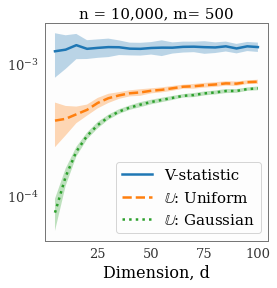

In [3]:
# Plotting figure
plt.figure(figsize=(4, 4))

plt.plot(dim, np.mean(MMDvals_Vstat, 0), label = "V-statistic", linewidth = 2.5)
plt.fill_between(dim, y1 = np.mean(MMDvals_Vstat, 0) + np.std(MMDvals_Vstat, 0),  
                 y2 = np.mean(MMDvals_Vstat, 0) - np.std(MMDvals_Vstat, 0), alpha = 0.3)

plt.plot(dim, np.mean(MMDvals_weighted_uniform, 0), label = "$\mathbb{U}$: Uniform", linewidth = 2.5, linestyle = "dashed")
plt.fill_between(dim, y1 = np.mean(MMDvals_weighted_uniform, 0) + np.std(MMDvals_weighted_uniform, 0),  
                 y2 = np.mean(MMDvals_weighted_uniform, 0) - np.std(MMDvals_weighted_uniform, 0), alpha = 0.3)

plt.plot(dim, np.mean(MMDvals_weighted_gaussian, 0), label = "$\mathbb{U}$: Gaussian", linewidth = 2.5, linestyle = "dotted")
plt.fill_between(dim, y1 = np.mean(MMDvals_weighted_gaussian, 0) + np.std(MMDvals_weighted_gaussian, 0),  
                 y2 = np.mean(MMDvals_weighted_gaussian, 0) - np.std(MMDvals_weighted_gaussian, 0), alpha = 0.3)

plt.yscale("log")
plt.title("n = 10,000, m= 500", fontsize = 15)
plt.xlabel("Dimension, d", fontsize = 16)
plt.ylabel('$\widehat{\mathrm{MMD}}^2(\mathbb{P}^m_{\\theta}, \mathbb{P}^n_{\\theta})$', fontsize = 16)
plt.legend(fontsize = 15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.show()

### MMD error vs. number of samples (m) for different kernel choices
This code produces the results shown in Fig 3 (left)

In [24]:
# Parameter settings
m = np.arange(50, 550, 50)      # number of simulated samples
n = 10000                       # number of true samples
theta = [3, 1, 0.1, 0.1, 0.1]   # true theta
dim = 10                        # dimensions of data
N = 100                         # number of repetitions

In [25]:
MMDvals_weighted = np.zeros(shape = (N, len(m), 4))

np.random.seed(i)
_,_,y = sample_mvgandk(theta, n, dim)

# Compute the lengthscale
lengthscale = utils.median_heuristic(y)

for j in range(len(m)):

    for i in range(N):
        
        u,u_normal,x = sample_mvgandk(theta, m[j], dim, method = "MC")
        
        z = utils.embedding_unif(u)
        w = utils.computeWeights(u, z)

        # Compute optimally-weighted MMD
        MMDvals_weighted[i, j, 0] = utils.MMD_weighted(x, y, w, lengthscale, kernel = "Gaussian")
        MMDvals_weighted[i, j, 1] = utils.MMD_weighted(x, y, w, lengthscale, kernel = "Matern", nu = 2.5)

        w = compute_weights_ProdMatern(u, dim, m[j])

        # Compute optimally-weighted MMD
        MMDvals_weighted[i, j, 2] = utils.MMD_weighted(x, y, w, lengthscale, kernel = "Gaussian")
        MMDvals_weighted[i, j, 3] = utils.MMD_weighted(x, y, w, lengthscale, kernel = "Matern", nu = 2.5)

    print(j)

0
1
2
3
4
5
6
7
8
9


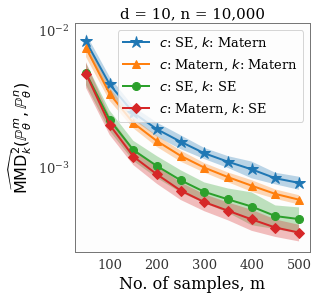

In [5]:
# Plotting
nPoints = len(m)
plt.figure(figsize=(4.2, 4.2))

plt.plot(m, np.mean(MMDvals_weighted, axis = 0)[:,1],'-*', markersize = 12, label = "$c$: SE, $k$: Matern")
plt.fill_between(m[0:nPoints], y1 = np.mean(MMDvals_weighted, 0)[0:nPoints,1] + np.std(MMDvals_weighted, 0)[0:nPoints,1],  
                 y2 = np.mean(MMDvals_weighted, 0)[0:nPoints,1] - np.std(MMDvals_weighted, 0)[0:nPoints,1], alpha = 0.3)

plt.plot(m[0:nPoints], np.mean(MMDvals_weighted, axis = 0)[0:nPoints,3],'-^', markersize = 8, label = "$c$: Matern, $k$: Matern")
plt.fill_between(m[0:nPoints], y1 = np.mean(MMDvals_weighted, 0)[0:nPoints,3] + np.std(MMDvals_weighted, 0)[0:nPoints,3],  
                 y2 = np.mean(MMDvals_weighted, 0)[0:nPoints,3] - np.std(MMDvals_weighted, 0)[0:nPoints,3], alpha = 0.3)

plt.plot(m[0:nPoints], np.mean(MMDvals_weighted, axis = 0)[0:nPoints,0], '-o',markersize = 8, label = "$c$: SE, $k$: SE")
plt.fill_between(m[0:nPoints], y1 = np.mean(MMDvals_weighted, 0)[0:nPoints,0] + np.std(MMDvals_weighted, 0)[0:nPoints,0],  
                 y2 = np.mean(MMDvals_weighted, 0)[0:nPoints,0] - np.std(MMDvals_weighted, 0)[0:nPoints,0], alpha = 0.3)

plt.plot(m[0:nPoints], np.mean(MMDvals_weighted, axis = 0)[0:nPoints,2],'-D', markersize = 7, label = "$c$: Matern, $k$: SE")
plt.fill_between(m[0:nPoints], y1 = np.mean(MMDvals_weighted, 0)[0:nPoints,2] + np.std(MMDvals_weighted, 0)[0:nPoints,2],  
                 y2 = np.mean(MMDvals_weighted, 0)[0:nPoints,2] - np.std(MMDvals_weighted, 0)[0:nPoints,2], alpha = 0.3)

plt.yscale('log')
plt.title('d = 10, n = 10,000', fontsize=15)
plt.xlabel("No. of samples, m", fontsize=16)
plt.ylabel('$\widehat{\mathrm{MMD}}_k^2(\mathbb{P}^m_{\\theta}, \mathbb{P}^n_{\\theta})$', fontsize=16)
plt.legend(fontsize=13, frameon = True)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.show()

### MMD error vs. parameter values
This code produces the results shown in Fig 3 (centre-right)

In [6]:
# Parameter settings
m = 500                                               # number of simulated samples
n = 10000                                             # number of true samples
dim = 10                                              # dimensions of data
theta = [3, 1, 0.1, 0.1, 0.1]                         # true theta
k = [0,0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

N = 100

In [7]:
MMDvals_Vstat = np.zeros(shape = (N,len(k)))
MMDvals_weighted_uniform = np.zeros(shape = (N,len(k)))
MMDvals_weighted_gaussian = np.zeros(shape = (N,len(k)))

for j in range(len(k)):
#     theta[3] = k[j]   # Uncomment this for varying k
    theta[2] = k[j]   # Uncomment this for varying g

    for i in range(N):

        _,_,y = sample_mvgandk(theta, n, dim)
        u,u_normal,x = sample_mvgandk(theta, m, dim, method = "MC")
        
        # Compute the lengthscale
        lengthscale = utils.median_heuristic(y)
        
        # Compute MMD using V-statistic
        MMDvals_Vstat[i,j] = utils.MMD_unweighted(x, y, lengthscale)
        
        # Compute optimally-weighted MMD
        MMDvals_weighted_uniform[i,j] = MMD_weighted_general(x, y, u, lengthscale, measure = "Uniform")
        MMDvals_weighted_gaussian[i,j] = MMD_weighted_general(x, y, u_normal, lengthscale, measure = "Gaussian")
        
#     print(j)

#### For plotting versus k

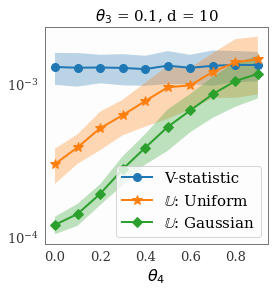

In [6]:
# For plotting versus k
plt.figure(figsize=(4, 4))
plt.plot(k, np.mean(MMDvals_Vstat, 0), '-o',  markersize = 8, label = "V-statistic")
plt.fill_between(k, y1 = np.mean(MMDvals_Vstat, 0) + np.std(MMDvals_Vstat, 0),  
                 y2 = np.mean(MMDvals_Vstat, 0) - np.std(MMDvals_Vstat, 0), alpha = 0.3)

plt.plot(k, np.mean(MMDvals_weighted_uniform, 0), '-*', markersize = 11, label = "$\mathbb{U}$: Uniform")
plt.fill_between(k, y1 = np.mean(MMDvals_weighted_uniform, 0) + np.std(MMDvals_weighted_uniform, 0),  
                 y2 = np.mean(MMDvals_weighted_uniform, 0) - np.std(MMDvals_weighted_uniform, 0), alpha = 0.3)

plt.plot(k, np.mean(MMDvals_weighted_gaussian, 0), '-D', markersize = 7, label = "$\mathbb{U}$: Gaussian")
plt.fill_between(k, y1 = np.mean(MMDvals_weighted_gaussian, 0) + np.std(MMDvals_weighted_gaussian, 0),  
                 y2 = np.mean(MMDvals_weighted_gaussian, 0) - np.std(MMDvals_weighted_gaussian, 0), alpha = 0.3)

plt.yscale("log")
plt.title("$\\theta_3$ = 0.1, d = 10", fontsize = 15)
plt.xlabel('$\\theta_4$', fontsize = 16)
plt.legend(fontsize = 15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.show()

#### For plotting versus g

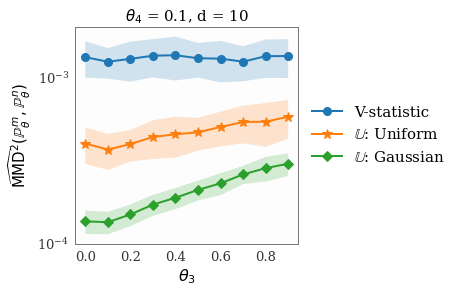

In [7]:
g = [0,0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(4, 4))
plt.plot(g, np.mean(MMDvals_Vstat, 0), '-o', markersize = 8, label = "V-statistic")
plt.fill_between(g, y1 = np.mean(MMDvals_Vstat, 0) + np.std(MMDvals_Vstat, 0),  
                 y2 = np.mean(MMDvals_Vstat, 0) - np.std(MMDvals_Vstat, 0), alpha = 0.2)

plt.plot(g, np.mean(MMDvals_weighted_uniform, 0), '-*', markersize = 11, label = "$\mathbb{U}$: Uniform")
plt.fill_between(g, y1 = np.mean(MMDvals_weighted_uniform, 0) + np.std(MMDvals_weighted_uniform, 0),  
                 y2 = np.mean(MMDvals_weighted_uniform, 0) - np.std(MMDvals_weighted_uniform, 0), alpha = 0.2)

plt.plot(g, np.mean(MMDvals_weighted_gaussian, 0), '-D', markersize = 7, label = "$\mathbb{U}$: Gaussian")
plt.fill_between(g, y1 = np.mean(MMDvals_weighted_gaussian, 0) + np.std(MMDvals_weighted_gaussian, 0),  
                 y2 = np.mean(MMDvals_weighted_gaussian, 0) - np.std(MMDvals_weighted_gaussian, 0), alpha = 0.2)

plt.yscale("log")
plt.title("$\\theta_4$ = 0.1, d = 10", fontsize = 15)
plt.xlabel('$\\theta_3$', fontsize = 16)
plt.ylabel('$\widehat{\mathrm{MMD}}^2(\mathbb{P}^m_{\\theta}, \mathbb{P}^n_{\\theta})$', fontsize=15)
plt.legend(fontsize = 15, bbox_to_anchor=(1.0, 0.7), ncol = 1, frameon = False)

plt.yticks(fontsize=13)
plt.xticks(fontsize=13)

plt.show()

## Computational cost vs. Error
This code produces the results shown in Fig 3 (right).

In [58]:
# Parameter settings
n = np.array([200, 500, 1000, 2000])          # number of observed samples (same as m for V-statistic)
m = (np.round(2* n**(2/3))).astype(int)       # number of simulated samples for OW estimator

theta = [3, 1, 0.1, 0.1, 0.1]                 # true theta
dim = 5                                       # dimensions of data

N = 10                                        # number of repetitions per n

### V-statistic

In [59]:
MMDvals_Vstat = np.zeros(shape = (N, len(m)))
Cost_Vstat = np.zeros(shape = (N, len(m)))

for j in range(len(m)):

    for i in range(N):
        
        # get the start time
        st = time.time()
        
        _,_,y = sample_mvgandk(theta, n[j], dim)

        # Compute the lengthscale
        lengthscale = utils.median_heuristic(y)
        
        u,u_normal,x = sample_mvgandk(theta, n[j], dim, method = "MC")
        
        # Compute MMD using V-statistic
        MMDvals_Vstat[i,j] = utils.MMD_unweighted(x, y, lengthscale)
        
        # get the end time
        et = time.time()

        Cost_Vstat[i,j] = et - st


0
1
2
3


### Optimally Weighted

In [60]:
MMDvals_weighted = np.zeros(shape = (N, len(m)))
Cost_weighted = np.zeros(shape = (N, len(m)))

for j in range(len(m)):

    for i in range(N):
        
        # get the start time
        st = time.time()
        
        _,_,y = sample_mvgandk(theta, n[j], dim)

        # Compute the lengthscale
        lengthscale = utils.median_heuristic(y)
        
        # Sample u's and x's from the model        
        u,u_normal,x = sample_mvgandk(theta, m[j], dim, method = "MC")
        
        # Compute optimally-weighted MMD
        z = utils.embedding_Gaussian(u_normal)
        w = utils.computeWeights(u_normal, z)
        
        MMDvals_weighted[i,j] = utils.MMD_weighted(x, y, w, lengthscale)
        
        # get the end time
        et = time.time()

        Cost_weighted[i,j] = et - st

0
1
2
3


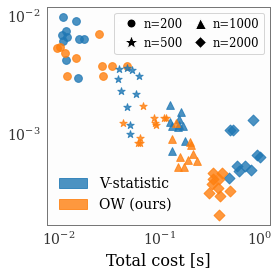

In [66]:
# Plotting
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
from matplotlib.patches import Patch

point_marker = np.array(["o", '*', "^", "D", "X"]) 

legend_elements = [Line2D([0], [0], marker='o', color='w', label='n=200',markerfacecolor='0',  markersize=9),
                          Line2D([0], [0], marker='*', color='w', label='n=500',markerfacecolor='0',  markersize=15),
                          Line2D([0], [0], marker='^', color='w', label='n=1000',markerfacecolor='0',  markersize=11),
                          Line2D([0], [0], marker='D', color='w', label='n=2000',markerfacecolor='0',  markersize=9)]

legend_elements_MMD = [Patch(facecolor='C0', edgecolor='C0', label='V-statistic', alpha = 0.8),
                   Patch(facecolor='C1', edgecolor='C1', label='OW (ours)', alpha = 0.8)]


plt.figure(figsize=(4, 4))
for i in range(len(m)):
    plt.scatter(Cost_Vstat[:, i], MMDvals_Vstat[:,i], marker = point_marker[i], color = "C0", s = 60, alpha = 0.8)
    plt.scatter(Cost_weighted[:, i], MMDvals_weighted[:,i], marker = point_marker[i], color = "C1", s = 60, alpha = 0.8)
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Total cost [s]', fontsize = 16)

first_legend = plt.legend(handles=legend_elements, loc='upper right', ncol = 2, frameon = True,
                          columnspacing=0.5, handletextpad=0.1)
plt.gca().add_artist(first_legend)
plt.legend(handles=legend_elements_MMD, loc='lower left', frameon = False, fontsize = 14)

plt.ylabel('$\widehat{\mathrm{MMD}}^2(\mathbb{P}^m_{\\theta}, \mathbb{P}^n_{\\theta})$', fontsize=15)
plt.show()